In [1]:
# This script demonstrates the capabilities of cluster_slug by using
# it to re-analyze the M31 star clusters catalog of Johnson et al. (2015, ApJ)

# Import the libraries we'll need
from astropy.io import ascii
from astropy.io import fits
import emcee
from astropy import table
from astropy.table import unique, Table, hstack, Column
import sys
from numpy import inf
import numpy as np
import numpy.ma as ma
import time
from matplotlib.pyplot import figure as fig
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from slugpy.cluster_slug import cluster_slug
from slugpy import * 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

In [2]:
#Imported AP fits files which include best fit of mass and age data already 

apdata = Table.read('apdata-cluster_6phot+agemass.fits')
print("Reading AP Cluster Data (Phot+Agemasss)...")
apdata_12clusters = Table.read('apdata-cluster_6phot+agemass_select.fits')
print("Reading AP 12 Cluster Data (Phot+AgeMass)...")

apdata_good_phot6filts=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Photometery_Tables/apdata_goodphot_6filts.fits')


LEGUS_PHAT_PadKroupa_prop=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_prop.fits')
LEGUS_PHAT_PadKroupa_phot=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_phot.fits')

dmod_M31=24.47 

Reading AP Cluster Data (Phot+Agemasss)...
Reading AP 12 Cluster Data (Phot+AgeMass)...


In [3]:
apdata_BM_CMD=apdata['BEST_METHOD']

In [5]:
indCMD=np.where(apdata_BM_CMD!='M')
#indBTM=np.where(apdata_good_phot6filts_BT=='M')
apdata.remove_rows(indCMD)

In [6]:
apdata_good_phot6filts['CMD_AV_BEST']

0.0
0.0
0.45
0.5
0.75
0.7
0.5
0.0
0.5
1.75
0.3


In [201]:
ind_logAge_9orless=np.where((apdata['BEST_AGE'])<9)
apdata.remove_rows(ind_logAge_9orless)

In [4]:
#Extract photometry from the AP PHAT catalog and pack it into arrays
cluster_id = np.array(apdata_good_phot6filts['ID'])

#F275W filter with error
apdata_good_phot6filts['MAG275'][apdata_good_phot6filts['MAG275'] == 'INDEF'] = -99
m275 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG275'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG275'][apdata_good_phot6filts['SIG275'] == 'INDEF'] = -99
m275err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG275'], 
                                   dtype='float64'), -99)

#F336W filter with error
apdata_good_phot6filts['MAG336'][apdata_good_phot6filts['MAG336'] == 'INDEF'] = -99
m336 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG336'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG336'][apdata_good_phot6filts['SIG336'] == 'INDEF'] = -99
m336err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG336'], 
                                   dtype='float64'), -99)

#F475W filter with error
apdata_good_phot6filts['MAG475'][apdata_good_phot6filts['MAG475'] == 'INDEF'] = -99
m475 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG475'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG475'][apdata_good_phot6filts['SIG475'] == 'INDEF'] = -99
m475err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG475'],
                                   dtype='float64'), -99)
#F814W filter with error
apdata_good_phot6filts['MAG814'][apdata_good_phot6filts['MAG814'] == 'INDEF'] = -99
m814 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG814'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG814'][apdata_good_phot6filts['SIG814'] == 'INDEF'] = -99
m814err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG814'],
                                   dtype='float64'), -99)

#F110W filter with error
apdata_good_phot6filts['MAG110'][apdata_good_phot6filts['MAG110'] == 'INDEF'] = -99
m110 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG110'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG110'][apdata_good_phot6filts['SIG110'] == 'INDEF'] = -99
m110err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG110'],
                                   dtype='float64'), -99)

#F160W filter with error 
apdata_good_phot6filts['MAG160'][apdata_good_phot6filts['MAG160'] == 'INDEF'] = -99
m160 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG160'],dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG160'][apdata_good_phot6filts['SIG160'] == 'INDEF'] = -99
m160err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG160'],
                                   dtype='float64'), -99)

apdata_good_phot6filts_logm=apdata_good_phot6filts['BEST_MASS']
apdata_good_phot6filts_logt=apdata_good_phot6filts['BEST_AGE']
apdata_good_phot6filts_logx=apdata_good_phot6filts['CMD_AV_BEST']

/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


In [5]:
# Mask entries with bad data in one or more filters for the actual M31 data
valid = np.logical_and(np.logical_not(m275.mask),
                       np.logical_not(m336.mask))
valid = np.logical_and(valid, np.logical_not(m475.mask))
valid = np.logical_and(valid, np.logical_not(m814.mask))
valid = np.logical_and(valid, np.logical_not(m110.mask))
valid = np.logical_and(valid, np.logical_not(m160.mask))

In [6]:
# Create array of photometry to pass to cluster_slug
phot=np.zeros((np.sum(616), 6)) #Creating an empty array of zeros with the shape of 2753x6 
photerr=np.zeros((np.sum(616), 6))#Creating an empty array of zeros with the shape of 2753x6 

In [7]:
#Defining the filters defined in the parameter file. Filters used for M3!
phot[:,0] = m275[valid]
phot[:,1] = m336[valid]
phot[:,2] = m475[valid]
phot[:,3] = m814[valid]
phot[:,4] = m110[valid]
phot[:,5] = m160[valid] 
photerr[:,0] = m275err[valid]
photerr[:,1] = m336err[valid]
photerr[:,2] = m475err[valid]
photerr[:,3] = m814err[valid]
photerr[:,4] = m110err[valid]
photerr[:,5] = m160err[valid] 

# Set up filter list (Commented out the original list of filters originally for chdata) for M31 AP PHAT 
filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', 'ACS_F475W', 'ACS_F814W', 
           'WFC3_IR_F110W', 'WFC3_IR_F160W']

In [8]:
# Define the sample density (For AP PHAT Data)
def sample_density(physprop):
    logm = physprop[:,0]
    logt = physprop[:,1]
    #logx = physprop[:,2]
    sden = np.ones(len(logm))
    sden[logm > 4] = sden[logm > 4] * 1.0/10.**(logm[logm > 4]-4)
    sden[logt > 8] = sden[logt > 8] * 1.0/10.**(logt[logt > 8]-8)
    #sden[logx > 12]= sden[logx >12] * 1.0/10.**(logx[logx >12]-12)
    return sden

In [9]:
# Set up the cluster_slug object; this command will take care of
# reading the library and converting the data to the Vega photometric
# system
print("Reading cluster_slug library...")
cs=cluster_slug(photsystem='Vega', filters=filters, bw_phot=0.25,
                ktype='gaussian',sample_density=sample_density,
                libname='LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials')
# Set priors to be flat in log T and A_V, but vary with logm as
# p(log M) ~ 1/M
def priorfunc(physprop):
    # Note: physprop is an array of shape (N, 3) where physprop[:,0] =
    # log M, physprop[:,1] = log T, physprop[:,2] = A_V
    return 1.0/np.exp(physprop[:,0])
cs.priors = priorfunc

Reading cluster_slug library...


Computing posterior PDFs...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Computation time: 185.627125 seconds total, 0.150671 seconds / PDF


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


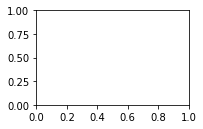

In [10]:
# Start timing
print("Computing posterior PDFs...")
lasttime = time.clock()


# Compute marginal PDFs of mass and age
logm, mpdf = cs.mpdf(0, phot, photerr, filters=filters)
logt, tpdf = cs.mpdf(1, phot, photerr, filters=filters)


# End timing
newtime = time.clock()
tottime = newtime - lasttime

# Print timing results
print("Computation time: {:f} seconds total, {:f} seconds / PDF".
      format(tottime, tottime/phot.shape[0]/2))

# Set up a plot window
plt.figure(1, figsize=(6,8))
plt.subplot(4,2,1)

In [11]:
logx, xpdf = cs.mpdf(2, phot, photerr, ngrid=1000, filters=filters)

In [12]:
# Compute the mean of the posterior PDFs returned by cluster_slug
mmean = np.sum(logm*mpdf*(logm[1]-logm[0]), axis=1)
tmean = np.sum(logt*tpdf*(logt[1]-logt[0]), axis=1)
xmean = np.sum(logx*xpdf*(logx[1]-logt[0]), axis=1)

# Compute the 25th, 50th, and 75th percentiles of the posterior PDFs
mpdfsum = np.cumsum(mpdf, axis=1)*(logm[1]-logm[0])
mpercentiles = np.array([
    logm[np.argmax(np.greater(mpdfsum, 0.1), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.5), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.9), axis=1)]])
tpdfsum = np.cumsum(tpdf, axis=1)*(logt[1]-logt[0])
tpercentiles = np.array([
    logt[np.argmax(np.greater(tpdfsum, 0.1), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.5), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.9), axis=1)]])
xpdfsum = np.cumsum(xpdf, axis=1)*(logx[1]-logx[0])
xpercentiles = np.array([
    logx[np.argmax(np.greater(xpdfsum, 0.1), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.5), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.9), axis=1)]])

In [13]:
# For each model, find the best match in the library for the 12 hand-picked clusters
matches, dist = cs.bestmatch(phot, filters=filters, nmatch=1)
dist = dist/np.sqrt(len(filters))

In [14]:
mp25=mpercentiles[0]
mp50=mpercentiles[1]
mp75=mpercentiles[2]
tp25=tpercentiles[0]
tp50=tpercentiles[1]
tp75=tpercentiles[2]
xp25=xpercentiles[0]
xp50=xpercentiles[1]
xp75=xpercentiles[2]

In [15]:
pmatches, dist = cs.bestmatch(phot, filters=filters, nmatch=100)

In [16]:
phot_matches=(pmatches[:,:,-6:])+dmod_M31
m_matches=matches[:,:-8]
t_matches=matches[:,1:-7]
x_matches=matches[:,2:-6]

In [17]:
mpdf

array([[1.98691255e-01, 2.35901181e-01, 2.70573091e-01, ...,
        2.63401673e-04, 2.41127797e-04, 2.34987190e-04],
       [2.07984380e-01, 2.48264772e-01, 2.86232266e-01, ...,
        3.22545574e-04, 3.17364994e-04, 3.16271575e-04],
       [6.99146667e-02, 8.56925739e-02, 1.01993502e-01, ...,
        1.90287399e-04, 1.90287399e-04, 1.90287399e-04],
       ...,
       [1.22360325e+00, 1.46640126e+00, 1.68972920e+00, ...,
        1.13236598e-02, 1.11664308e-02, 1.05530800e-02],
       [3.17430134e-02, 3.68925178e-02, 4.13794610e-02, ...,
        1.95140614e+00, 1.71072490e+00, 1.45139812e+00],
       [2.51886301e-02, 3.04970468e-02, 3.57170130e-02, ...,
        8.64565527e-01, 7.20460152e-01, 5.82905636e-01]])

In [18]:
diffPDFmed_M_apdata=apdata_good_phot6filts_logm-mpercentiles[1]
diffPDFmed_A_apdata=apdata_good_phot6filts_logt-tpercentiles[1]
diffPDFmed_X_apdata=apdata_good_phot6filts_logx-xpercentiles[1]


In [19]:
apdata_good_phot6filts_BT=apdata_good_phot6filts['BEST_METHOD']

In [20]:
indBT=np.where(apdata_good_phot6filts_BT!='M')
indBTM=np.where(apdata_good_phot6filts_BT=='M')
apdata_good_phot6filts.remove_rows(indBT)

In [21]:
max(apdata_good_phot6filts['BEST_MASS'])

5.1209774

In [22]:
len(apdata_good_phot6filts_logm[indBTM[0]])

358

In [23]:
#Difference of the median of the Mass PDF & the previous mass apdata estimates for only CMD estimates in apdata
diff_PDFMedian_m_apdata=apdata_good_phot6filts_logm[indBTM[0]]-mpercentiles[1][indBTM[0]]


In [40]:
diff_PDFMedian_m_apdata_arr=np.array(diff_PDFMedian_m_apdata)
diff_PDFMedian_m_apdata_arr=np.reshape(diff_PDFMedian_m_apdata_arr, (358,1))

In [42]:
diff_PDFMedian_m_apdata_Table=Table([diff_PDFMedian_m_apdata_arr], names=('6'))
diff_PDFMedian_m_apdata_Table

6 [1]
float64
-0.029632509789951023
0.14977197938854836
0.24778360423285983
0.07980809270694156
-0.0006179223876072726
-0.16846951509145836
-0.35577188999370346
0.20139426287848972
0.4545073371686703


In [43]:
diff_PDFMedian_m_apdata_Table.write('diff_PDFMedian_m_apdata6filt.fits')

In [24]:
#Difference of the median of the Age PDF & the previous age apdata estimates for only CMD estimates in apdata
diff_PDFMedian_t_apdata=apdata_good_phot6filts_logt[indBTM[0]]-tpercentiles[1][indBTM[0]]

In [45]:
diff_PDFMedian_t_apdata_arr=np.array(diff_PDFMedian_t_apdata)
diff_PDFMedian_t_apdata_arr=np.reshape(diff_PDFMedian_t_apdata_arr, (358,1))

In [46]:
diff_PDFMedian_t_apdata_Table=Table([diff_PDFMedian_t_apdata_arr], names=('6'))
diff_PDFMedian_t_apdata_Table

6 [1]
float64
0.13228323086216243
0.3267717821904874
0.8251964764918869
-0.34330727615371703
0.07480332923422495
0.2086613675374096
-0.9551174216867082
0.15275581793375537
0.4677163841290852


In [47]:
diff_PDFMedian_t_apdata_Table.write('diff_PDFMedian_t_apdata6filt.fits')

In [25]:
#Difference of the median of the Av PDF & the previous Av apdata estimates for only CMD estimates in apdata
diff_PDFMedian_x_apdata=apdata_good_phot6filts_logx[indBTM[0]]-xpercentiles[1][indBTM[0]]

In [49]:
diff_PDFMedian_x_apdata_arr=np.array(diff_PDFMedian_x_apdata)
diff_PDFMedian_x_apdata_arr=np.reshape(diff_PDFMedian_x_apdata_arr, (358,1))

In [50]:
diff_PDFMedian_x_apdata_Table=Table([diff_PDFMedian_x_apdata_arr], names=('6'))
diff_PDFMedian_x_apdata_Table

6 [1]
float64
-0.258708989039506
-0.20870897711857705
-0.2552595227951253
-0.00870898903950601
-0.2581340680646683
-0.10985879522639419
1.140141204773606
-0.26043369235937375
0.19359068293891524


In [51]:
diff_PDFMedian_x_apdata_Table.write('diff_PDFMedian_x_apdata6filt.fits')

In [26]:
sorted_mPDF_apdataMedian=np.sort(diff_PDFMedian_m_apdata)
diff_PDFMedian_m_apdata_25q=np.median(sorted_mPDF_apdataMedian[0:179])
diff_PDFMedian_m_apdata_75q=np.median(sorted_mPDF_apdataMedian[180:358])

In [27]:
#P25, Median, and P75 of CMD Log Mass and SLUG Mass Median
diff_PDFMedian_m_apdata_25q,np.median(diff_PDFMedian_m_apdata),diff_PDFMedian_m_apdata_75q

(-0.05741596003598515, 0.15899623853879485, 0.35425971134365075)

In [28]:
#IQR for Mass PDF Median - apdata (75th - 25th quartile values)
MassIQR=diff_PDFMedian_m_apdata_75q-diff_PDFMedian_m_apdata_25q
MassIQR

0.4116756713796359

In [29]:
#Sigma of Mass PDF Median - CMD Log Mass
np.std(diff_PDFMedian_m_apdata)

0.4552887037259016

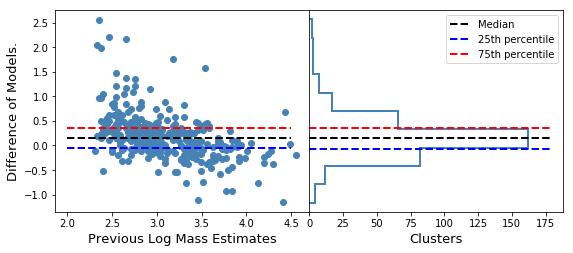

In [30]:
#Slug Masses vs CMD Masses with ONLY CMD BEST METHOD used 
x=np.arange(2,5,0.5)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(mpercentiles[1][indBTM[0]],diff_PDFMedian_m_apdata, color='steelblue')
plt.plot(x,np.median(diff_PDFMedian_m_apdata)*np.ones(6),'k--',lw=2)
plt.plot(x,diff_PDFMedian_m_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(x,diff_PDFMedian_m_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylabel('Difference of Models.', fontsize=13)
plt.xlabel('Previous Log Mass Estimates', fontsize=13);


plt.subplot(1,2,2)
a=np.arange(0,180,1)
plt.hist(diff_PDFMedian_m_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(a,np.median(diff_PDFMedian_m_apdata)*np.ones(180),'k--',lw=2,label='Median')
plt.plot(a,diff_PDFMedian_m_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
plt.plot(a,diff_PDFMedian_m_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDMassEst_vs_CMDMassEst_6filts.pdf')

In [31]:
sorted_tPDF_apdataMedian=np.sort(diff_PDFMedian_t_apdata)
diff_PDFMedian_t_apdata_25q=np.median(sorted_tPDF_apdataMedian[0:179])
diff_PDFMedian_t_apdata_75q=np.median(sorted_tPDF_apdataMedian[180:358])

In [32]:
len(sorted_tPDF_apdataMedian[179:358])

179

In [33]:
#IQR for Age PDF Median - apdata
diff_PDFMedian_t_apdata_75q-diff_PDFMedian_t_apdata_25q

0.6696847911711457

In [34]:
diff_PDFMedian_t_apdata_25q,np.median(diff_PDFMedian_t_apdata),diff_PDFMedian_t_apdata_75q

(-0.20629910329048773, 0.14724408315978632, 0.4633856878806579)

In [35]:
#standard deviation (sigma) of Age median of the PDF - Age apdata
np.std(diff_PDFMedian_t_apdata)

0.6236141347841173

In [36]:
#width of our Age distribution from p75 to p50(median)
diff_PDFMedian_t_apdata_75q-np.median(diff_PDFMedian_t_apdata), 

(0.3161416047208716,)

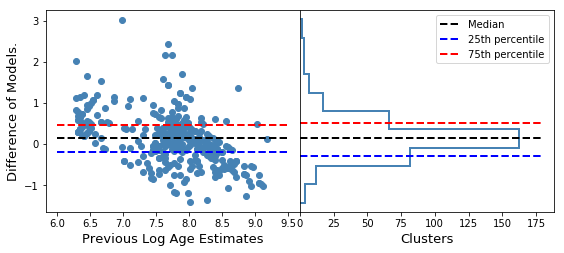

In [37]:
#Slug Ages vs CMD Ages with ONLY CMD BEST METHOD used 
Y=np.arange(6,10,0.5)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(tpercentiles[1][indBTM[0]],diff_PDFMedian_t_apdata, color='steelblue')
plt.plot(Y,np.median(diff_PDFMedian_t_apdata)*np.ones(8),'k--',lw=2)
plt.plot(Y,diff_PDFMedian_t_apdata_25q*np.ones(8),'b--',lw=2)
plt.plot(Y,diff_PDFMedian_t_apdata_75q*np.ones(8),'r--',lw=2)
plt.ylabel('Difference of Models.', fontsize=13)
plt.xlabel('Previous Log Age Estimates', fontsize=13);

plt.subplot(1,2,2)
b=np.arange(0,180,1)
plt.hist(diff_PDFMedian_m_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(b,np.median(diff_PDFMedian_t_apdata)*np.ones(180),'k--',lw=2,label='Median')
plt.plot(b,diff_PDFMedian_t_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
plt.plot(b,diff_PDFMedian_t_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()
plt.xlabel('Clusters', fontsize=13);

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDAgeEst_vs_CMDAgeEst_6filts.pdf')


In [38]:
diff_PDFMedian_t_apdata_25q,np.median(diff_PDFMedian_t_apdata),diff_PDFMedian_t_apdata_75q

(-0.20629910329048773, 0.14724408315978632, 0.4633856878806579)

In [39]:
#Log Age IQR
AgeIQR=diff_PDFMedian_t_apdata_75q-diff_PDFMedian_t_apdata_25q
AgeIQR

0.6696847911711457

In [40]:
#width of our Age distribution from p75 to p50(median)
diff_PDFMedian_t_apdata_75q-np.median(diff_PDFMedian_t_apdata), 

(0.3161416047208716,)

In [41]:
#width of our Age distribution from p50(median) to p25
np.median(diff_PDFMedian_t_apdata)-diff_PDFMedian_t_apdata_25q

0.35354318645027405

In [42]:
#width of our Mass distribution from p75 to p50(median)
diff_PDFMedian_m_apdata_75q-np.median(diff_PDFMedian_m_apdata)

0.1952634728048559

In [43]:
#width of our Age distribution from p50(median) to p25
np.median(diff_PDFMedian_m_apdata)-diff_PDFMedian_m_apdata_25q

0.21641219857478

In [44]:
#PERCENTILES FOR EXTINCTION differences for clusters with CMD best method
sorted_xPDF_apdataMedian=np.sort(diff_PDFMedian_x_apdata)
diff_PDFMedian_x_apdata_25q=np.median(sorted_xPDF_apdataMedian[0:179])
diff_PDFMedian_x_apdata_75q=np.median(sorted_xPDF_apdataMedian[180:358])


In [45]:
diff_PDFMedian_x_apdata_25q, np.median(diff_PDFMedian_x_apdata),diff_PDFMedian_x_apdata_75q

(-0.405834419928105, -0.05842154047301612, 0.39129104672328086)

In [46]:
#IQR for Extinction PDF Median - apdata
diff_PDFMedian_x_apdata_75q-diff_PDFMedian_x_apdata_25q

0.7971254666513858

In [47]:
np.std(diff_PDFMedian_x_apdata)

2.66527014273898

In [48]:
#PERCENTILES FOR EXTINCTION differences for clusters WITHOUT CMD best method
sorted_Xpdf_apdataMedian=np.sort(diffPDFmed_X_apdata)
diff_PDFMedian_X_apdata_25q=np.median(sorted_xPDF_apdataMedian[0:307])
diff_PDFMedian_X_apdata_75q=np.median(sorted_xPDF_apdataMedian[308:616])

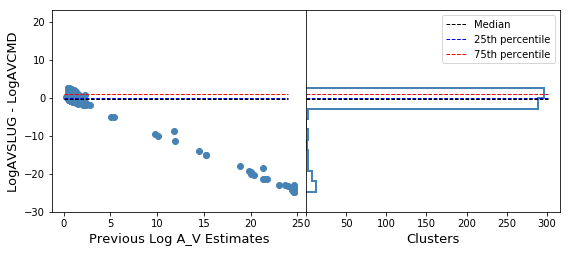

In [49]:
#plotting the median of the PDF versus the difference of the apdata Av minus the median of the PDF for all 
#apdata clusters with and without best method CMD
z=np.arange(0,25,1)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(xpercentiles[1],diffPDFmed_X_apdata, color='steelblue')
plt.plot(z,np.median(diffPDFmed_X_apdata)*np.ones(25),'k--',lw=1)
plt.plot(z,diff_PDFMedian_X_apdata_25q*np.ones(25),'b--',lw=1)
plt.plot(z,diff_PDFMedian_X_apdata_75q*np.ones(25),'r--',lw=1)
plt.ylim(-30,23)
#plt.xlim(0,5)
plt.ylabel('LogAVSLUG - LogAVCMD', fontsize=13)
plt.xlabel('Previous Log A_V Estimates', fontsize=13);


plt.subplot(1,2,2)
c=np.arange(0,302,1)
plt.hist(diffPDFmed_X_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(c,np.median(diffPDFmed_X_apdata)*np.ones(302),'k--',lw=1,label='Median')
plt.plot(c,diff_PDFMedian_X_apdata_25q*np.ones(302),'b--',lw=1,label='25th percentile')
plt.plot(c,diff_PDFMedian_X_apdata_75q*np.ones(302),'r--',lw=1,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.ylim(-30,23)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
#plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/Model_Comparison_Files/DiffofMassModels_vs_PreviousMassEst.pdf')

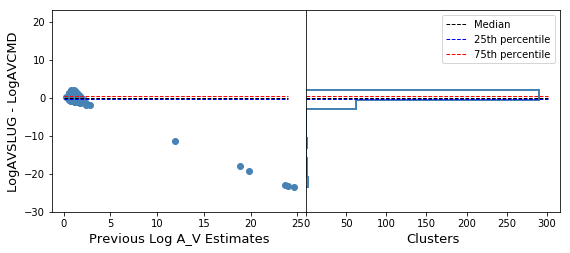

In [50]:
#plotting the median of the PDF versus the difference of the apdata Av minus the median of the PDF for all 
#apdata clusters with ONLY best method CMD

z=np.arange(0,25,1)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(xpercentiles[1][indBTM[0]],diff_PDFMedian_x_apdata, color='steelblue')
plt.plot(z,np.median(diff_PDFMedian_x_apdata)*np.ones(25),'k--',lw=1)
plt.plot(z,diff_PDFMedian_x_apdata_25q*np.ones(25),'b--',lw=1)
plt.plot(z,diff_PDFMedian_x_apdata_75q*np.ones(25),'r--',lw=1)
plt.ylim(-30,23)
#plt.xlim(0,5)
plt.ylabel('LogAVSLUG - LogAVCMD', fontsize=13)
plt.xlabel('Previous Log A_V Estimates', fontsize=13);


plt.subplot(1,2,2)
c=np.arange(0,302,1)
plt.hist(diff_PDFMedian_x_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(c,np.median(diff_PDFMedian_x_apdata)*np.ones(302),'k--',lw=1,label='Median')
plt.plot(c,diff_PDFMedian_x_apdata_25q*np.ones(302),'b--',lw=1,label='25th percentile')
plt.plot(c,diff_PDFMedian_x_apdata_75q*np.ones(302),'r--',lw=1,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.ylim(-30,23)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
#plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/Model_Comparison_Files/DiffofMassModels_vs_PreviousMassEst.pdf')

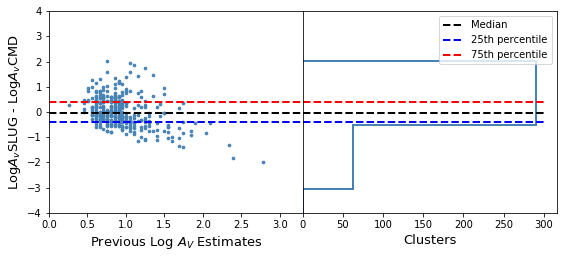

In [51]:
#Zoomed in version of the plot above between y values of -5 to 5

z=np.arange(0,6,1)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(xpercentiles[1][indBTM[0]],diff_PDFMedian_x_apdata, s=7, color='steelblue')
plt.plot(z,np.median(diff_PDFMedian_x_apdata)*np.ones(6),'k--',lw=2)
plt.plot(z,diff_PDFMedian_x_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(z,diff_PDFMedian_x_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylim(-4,4)
plt.xlim(0,3.3)
plt.ylabel('Log$A_v$SLUG - Log$A_v$CMD', fontsize=13)
plt.xlabel('Previous Log $A_V$ Estimates', fontsize=13);


plt.subplot(1,2,2)
c=np.arange(0,302,1)
plt.hist(diff_PDFMedian_x_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(c,np.median(diff_PDFMedian_x_apdata)*np.ones(302),'k--',lw=2,label='Median')
plt.plot(c,diff_PDFMedian_x_apdata_25q*np.ones(302),'b--',lw=2,label='25th percentile')
plt.plot(c,diff_PDFMedian_x_apdata_75q*np.ones(302),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.ylim(-4,4)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMD_AvEst_vs_CMD_AvEst_6filts.pdf')

(0, 4)

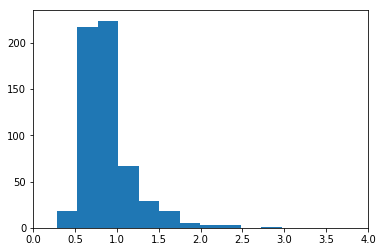

In [742]:
plt.hist(xpercentiles[1],bins=100)
plt.xlim(0,4)

(0, 4)

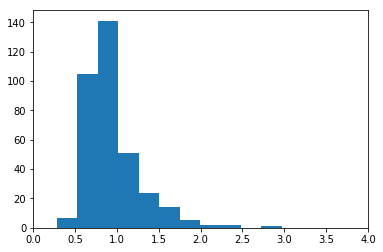

In [741]:
plt.hist(xpercentiles[1][indBTM[0]],bins=100)
plt.xlim(0,4)

In [83]:
Age_Stats=[0.15,0.26,-0.21,0.46,0.62]
Mass_Stats=[0.16,0.29,-0.057, 0.35,0.46]
Stat=['Median','IQR','P25','P75','SIGMA']
DiffMedPDF_apdataStats = Table([Stat, Mass_Stats, Age_Stats], names=('Values', 'Mass', 'Age'))
#DiffMedPDF_apdataStats.write('DiffMedPDF_apdataStats',format='aastex')

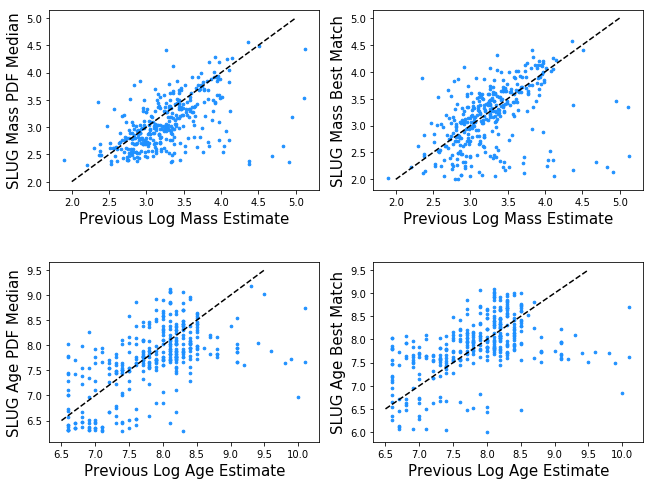

In [45]:
#Here we are comparing previous estimates of M31 Cluster Ages, Masses, and Extinction to the generated SLUG Best 
#Match models, and the PDFs 25th, median(50th), and 75th percentiles as well but we are only considering Previous
#estimates of BEST_METHOD of CMD ('M') identified clusters. 

X=np.arange(2,5.5,0.5)
Y=np.arange(6.5,9.6,0.5)

#plt.subplot(2,4,1)
#plt.plot(X,X,'k--')
#plt.scatter(apdata_good_phot6filts_logm[indBTM[0]],mpercentiles[0][indBTM[0]],s=4, color='dodgerblue')
#plt.xlabel('Previous Log Mass Estimate', fontsize=15)
#plt.ylabel('SLUG Mass PDF 25%', fontsize=15);


plt.subplot(2,2,1)
plt.plot(X,X,'k--')
plt.scatter(apdata_good_phot6filts_logm[indBTM[0]],mpercentiles[1][indBTM[0]],s=7, color='dodgerblue')
#plt.plot(MedMassquartile_25th*np.ones(7),X,'k-.')
#plt.plot(MedMassquartile_75th*np.ones(7),X,'r-.')
plt.xlabel('Previous Log Mass Estimate', fontsize=15)
plt.ylabel('SLUG Mass PDF Median', fontsize=15);

#plt.subplot(2,4,3)
#plt.plot(X,X,'k--')
#plt.scatter(apdata_good_phot6filts_logm[indBTM[0]],mpercentiles[2][indBTM[0]],s=4, color='dodgerblue')
#plt.xlabel('Previous Log Mass Estimate', fontsize=15)
#plt.ylabel('SLUG Mass PDF 75%', fontsize=15);

plt.subplot(2,2,2)
plt.plot(X,X,'k--')
plt.scatter(apdata_good_phot6filts_logm[indBTM[0]],m_matches[indBTM[0]],s=7, color='dodgerblue')
#plt.plot(BestMatch_mquartile_25th*np.ones(7),X,'k-.')
#plt.plot(BestMatch_mquartile_75th*np.ones(7),X,'r-.')
plt.xlabel('Previous Log Mass Estimate', fontsize=15)
plt.ylabel('SLUG Mass Best Match', fontsize=15);


#plt.subplot(2,4,5)
#plt.plot(Y,Y,'k--')
#plt.scatter(apdata_good_phot6filts_logt[indBTM[0]],tpercentiles[0][indBTM[0]],s=5, color='dodgerblue')
#plt.xlabel('Previous Log Age Estimate', fontsize=15)
#plt.ylabel('SLUG Age PDF 25%', fontsize=15);

plt.subplot(2,2,3)
plt.plot(Y,Y,'k--')
plt.scatter(apdata_good_phot6filts_logt[indBTM[0]],tpercentiles[1][indBTM[0]],s=7, color='dodgerblue')
#plt.plot(MedAgequartile_25th*np.ones(7),Y,'k-.')
#plt.plot(MedAgequartile_75th*np.ones(7),Y,'r-.')
plt.xlabel('Previous Log Age Estimate', fontsize=15)
plt.ylabel('SLUG Age PDF Median', fontsize=15);

#plt.subplot(2,4,7)
#plt.plot(Y,Y,'k--')
#plt.scatter(apdata_good_phot6filts_logt[indBTM[0]],tpercentiles[2][indBTM[0]],s=5, color='dodgerblue')
#plt.xlabel('Previous Log Age Estimate', fontsize=15)
#plt.ylabel('SLUG Age PDF 75%', fontsize=15);


plt.subplot(2,2,4)
plt.plot(Y,Y,'k--')
plt.scatter(apdata_good_phot6filts_logt[indBTM[0]],t_matches[indBTM[0]],s=7, color='dodgerblue')
#plt.plot(BestMatch_tquartile_25th*np.ones(7),Y,'k-.')
#plt.plot(BestMatch_tquartile_75th*np.ones(7),Y,'r-.')
plt.xlabel('Previous Log Age Estimate', fontsize=15)
plt.ylabel('SLUG Age Best Match', fontsize=15);

plt.savefig('SLUG PDF (25th,50th,75th)% & SLUG Best Match vs Previous Log Mass & Age Estimates (only_M_Best_Method).png')

plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.5, top=2, right=1.5)

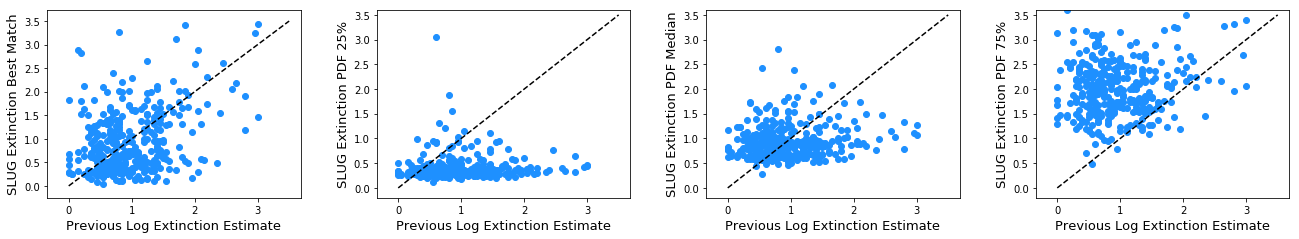

In [716]:
Z=np.arange(0,4,0.5)

plt.subplot(2,4,1)
plt.plot(Z,Z,'k--')
plt.scatter(apdata_good_phot6filts_logx[indBTM[0]],x_matches[indBTM[0]], color='dodgerblue')
plt.xlabel('Previous Log Extinction Estimate', fontsize=13)
plt.ylabel('SLUG Extinction Best Match', fontsize=13);

plt.subplot(2,4,2)
plt.plot(Z,Z,'k--')
plt.scatter(apdata_good_phot6filts_logx[indBTM[0]],xpercentiles[0][indBTM[0]], color='dodgerblue')
plt.ylim(-0.2,3.6)
plt.xlabel('Previous Log Extinction Estimate', fontsize=13)
plt.ylabel('SLUG Extinction PDF 25%', fontsize=13);

plt.subplot(2,4,3)
plt.plot(Z,Z,'k--')
plt.scatter(apdata_good_phot6filts_logx[indBTM[0]],xpercentiles[1][indBTM[0]], color='dodgerblue')
plt.ylim(-0.2,3.6)
plt.xlabel('Previous Log Extinction Estimate', fontsize=13)
plt.ylabel('SLUG Extinction PDF Median', fontsize=13);

plt.subplot(2,4,4)
plt.plot(Z,Z,'k--')
plt.scatter(apdata_good_phot6filts_logx[indBTM[0]],xpercentiles[2][indBTM[0]], color='dodgerblue')
plt.ylim(-0.2,3.6)
plt.xlabel('Previous Log Extinction Estimate', fontsize=13)
plt.ylabel('SLUG Extinction PDF 75%', fontsize=13);


plt.subplots_adjust(hspace=0.3, wspace=0.3, bottom=0.5, top=2, right=3)

In [717]:
diff_BMmedian_X_apdata=apdata_good_phot6filts_logx-x_matches_median

In [76]:
np.median(diff_BMmedian_X_apdata)

-0.21555208982044943

In [540]:
#25 and 75 percent of data of all best methods from 616 cluster subset (including non CMD Best Method clusters)
#for the best matches slug method
sorted_Xbm_apdataMedian=np.sort(diff_BMmedian_X_apdata)
diff_BMmedian_X_apdata_25q=np.median(sorted_Xbm_apdataMedian[0:308])
diff_BMmedian_X_apdata_75q=np.median(sorted_Xbm_apdataMedian[308:616])

In [726]:
#25 and 75 percent of data of all best methods from 616 cluster subset (including non CMD Best Method clusters)
#for the best matches slug method
sorted_X_apdataMedian=np.sort(diff_PDFMedian_x_apdata)
diff_BMmedian_X_apdata_25q=np.median(sorted_X_apdataMedian[0:308])
diff_BMmedian_X_apdata_75q=np.median(sorted_X_apdataMedian[308:616])

In [727]:
diff_BMmedian_X_apdata_25q, np.median(diff_BMmedian_X_apdata),diff_BMmedian_X_apdata_75q

(-0.14759064778370745, -0.21555208982044943, 0.8838959087794687)

In [728]:
#IQR for A_v non-CMD Best Method
diff_BMmedian_X_apdata_75q-diff_BMmedian_X_apdata_25q

1.0314865565631761

In [729]:
#Width of Distribution from P25 to Median for A_v non-CMD Best Method
np.median(diff_BMmedian_X_apdata)-diff_BMmedian_X_apdata_25q

-0.06796144203674198

In [730]:
#Width of Distribution from Median to P75 for A_v non-CMD Best Method
diff_BMmedian_X_apdata_75q-np.median(diff_BMmedian_X_apdata)

1.0994479985999182

In [731]:
(0.4856808801672294+0.5380282952402407)/2

0.511854587703735

In [732]:
np.std(diff_BMmedian_X_apdata)

0.90897681756601

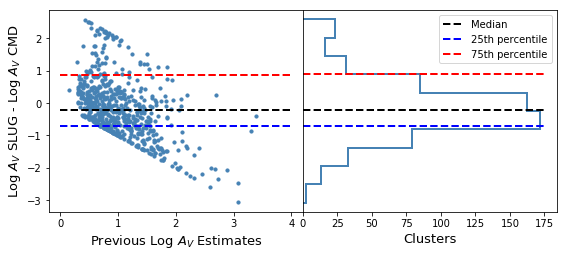

In [725]:
#Difference of the median of the A-v Best Match minus previous A_V apdata estimes for all clusters in apdata
#with and without CMD best method. 
x=np.linspace(0,4,6)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(x_matches_median,diff_BMmedian_X_apdata, color='steelblue',s=10)
plt.plot(x,np.median(diff_BMmedian_X_apdata)*np.ones(6),'k--',lw=2)
plt.plot(x,diff_BMmedian_X_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(x,diff_BMmedian_X_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylabel('Log $A_V$ SLUG - Log $A_V$ CMD', fontsize=13)
plt.xlabel('Previous Log $A_V$ Estimates', fontsize=13);


plt.subplot(1,2,2)
a=np.arange(0,176,1)
plt.hist(diff_BMmedian_X_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(a,np.median(diff_BMmedian_X_apdata)*np.ones(176),'k--',lw=2,label='Median')
plt.plot(a,diff_BMmedian_X_apdata_25q*np.ones(176),'b--',lw=2,label='25th percentile')
plt.plot(a,diff_BMmedian_X_apdata_75q*np.ones(176),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/Model_Comparison_Files/DiffofAvModels_vs_PreviousAvEst.pdf')


In [128]:
X_match_med_array=(np.array(x_matches_median))

In [550]:
#Difference of the median of the A-v Best Match minus previous A_V apdata estimes for only CMD estimates in apdata
diff_BMmedian_x_apdata=apdata_good_phot6filts_logx[indBTM[0]]-X_match_med_array[indBTM[0]]

In [557]:
len(sorted_xbm_apdataMedian[179:358])

179

In [558]:
#25 and 75 percent of data 
sorted_xbm_apdataMedian=np.sort(diff_BMmedian_x_apdata)
diff_BMmedian_x_apdata_25q=np.median(sorted_xbm_apdataMedian[0:179])
diff_BMmedian_x_apdata_75q=np.median(sorted_xbm_apdataMedian[179:358])

In [559]:
diff_BMmedian_x_apdata_25q, np.median(diff_BMmedian_x_apdata),diff_BMmedian_x_apdata_75q

(-0.44592564881860386, -0.056078827628175065, 0.3501415833815301)

In [560]:
#IQR for A_v CMD Best Method
diff_BMmedian_x_apdata_75q-diff_BMmedian_x_apdata_25q

0.796067232200134

In [150]:
#Width of Distribution from P25 to Median for A_v non-CMD Best Method
np.median(diff_BMmedian_x_apdata)-diff_BMmedian_x_apdata_25q

0.3898468211904288

In [152]:
#Width of Distribution from Median to P75 for A_v non-CMD Best Method
diff_BMmedian_x_apdata_75q-np.median(diff_BMmedian_x_apdata)

0.4062204110097052

In [153]:
#Avg of the width of the distribution
(0.3898468211904288+0.4062204110097052)/2

0.398033616100067

In [154]:
#standard deviation (sigma) of the difference of models
np.std(diff_BMmedian_x_apdata)

0.6364377512108964

In [ ]:
diffPDFmed_X_apdata

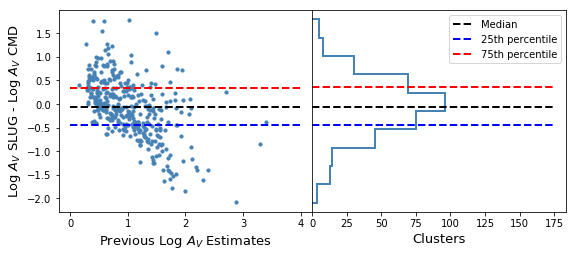

In [622]:
#Difference of the median of the A-v Best Match minus previous A_V apdata estimes for all clusters in apdata 
#ONLY with CMD best method clusters from apdata estimates. 

x=np.linspace(0,4,6)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(X_match_med_array[indBTM[0]], diff_BMmedian_x_apdata, color='steelblue',s=10)
plt.plot(x,np.median(diff_BMmedian_x_apdata)*np.ones(6),'k--',lw=2)
plt.plot(x,diff_BMmedian_x_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(x,diff_BMmedian_x_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylabel('Log $A_V$ SLUG - Log $A_V$ CMD', fontsize=13)
plt.xlabel('Previous Log $A_V$ Estimates', fontsize=13);


plt.subplot(1,2,2)
a=np.arange(0,176,1)
plt.hist(diff_BMmedian_x_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(a,np.median(diff_BMmedian_x_apdata)*np.ones(176),'k--',lw=2,label='Median')
plt.plot(a,diff_BMmedian_x_apdata_25q*np.ones(176),'b--',lw=2,label='25th percentile')
plt.plot(a,diff_BMmedian_x_apdata_75q*np.ones(176),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/Model_Comparison_Files/DiffofAvModels_vs_PreviousAvEst(ONLY_CMD).pdf')


Text(0.5, 0, 'Extinction [$A_V$]')

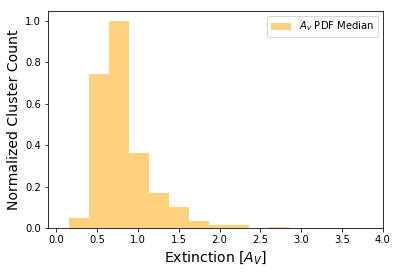

In [753]:
XMedsample = np.array(xpercentiles[1][indBTM[0]])
#generate bins boundaries and heights
XMedbin_height, XMedbin_boundary = np.histogram(XMedsample,bins=100)
#define width of each column
XMedwidth = XMedbin_boundary[1]-XMedbin_boundary[0]
#standardize each column by dividing with the maximum height
XMedbin_height = XMedbin_height/float(max(XMedbin_height))
#plot
plt.bar(XMedbin_boundary[:-1],XMedbin_height,width=XMedwidth,color='orange',alpha=0.5,label="$A_v$ PDF Median",lw=5)
plt.xlim(-0.1,4)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)

In [343]:
#Here I am trying to normalize the y-axis of the distribution of SLUG Av (%%%THIS DID NOT WORK%%%)
norm_SLUG_counts=[]
for i in range(len(xcounts)):
    norm_1=(xcounts[i])/(10000000)
    norm_SLUG_counts.append(norm_1)

In [344]:
yaxis_S_av=norm_SLUG_counts

In [624]:
apcounts, ap_bin_edges = np.histogram(apdata['CMD_AV_BEST'], bins=800)
apcounts, ap_bin_edges

2753

In [345]:
#Here I am trying to normalize the y-axis of the distribution of AP_DATA Av (%%%THIS DID NOT WORK%%%)
norm_ap_counts=[]
for i in range(len(xcounts)):
    norm_2=(xcounts[i])/(10000000)
    norm_ap_counts.append(norm_2)

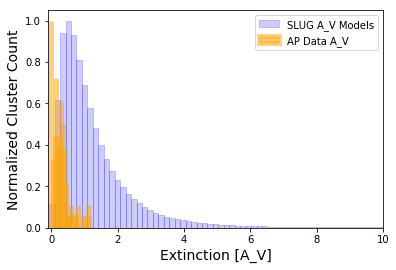

In [496]:
SLUGsample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
sbin_height,sbin_boundary = np.histogram(SLUGsample,bins=300)
#define width of each column
swidth = sbin_boundary[1]-sbin_boundary[0]
#standardize each column by dividing with the maximum height
sbin_height = sbin_height/float(max(sbin_height))
#plot
plt.bar(sbin_boundary[:-1],sbin_height,width=swidth,alpha=0.2,edgecolor='blue',color='blue',label="SLUG A_V Models")


APsample = np.array(apdata['CMD_AV_BEST'])
#generate bins boundaries and heights
APbin_height, APbin_boundary = np.histogram(APsample,bins=300)
#define width of each column
APwidth = APbin_boundary[1]-APbin_boundary[0]
#standardize each column by dividing with the maximum height
APbin_height = APbin_height/float(max(APbin_height))
#plot
plt.bar(APbin_boundary[:-1],APbin_height,width=APwidth,edgecolor='orange',color='orange',alpha=0.5,label="AP Data A_V ",lw=5)
plt.xlim(-0.1,10)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [A_V]',fontsize=14)

plt.show()

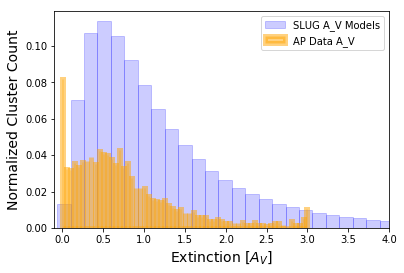

In [636]:
#Here I am running the same formula for normalizing both the SLUG and AP_data extinction values over the 
#y-axis by dividing the number of items in each bin by the max count of clusters in the data_set. 

SLUGsample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
sbin_height,sbin_boundary = np.histogram(SLUGsample,bins=300)
#define width of each column
swidth = sbin_boundary[1]-sbin_boundary[0]
#standardize each column by dividing with the maximum height
sbin_height = sbin_height/(10000000)
#plot
plt.bar(sbin_boundary[:-1],sbin_height,width=swidth,alpha=0.2,edgecolor='blue',color='blue',label="SLUG A_V Models")


APsample = np.array(apdata['CMD_AV_BEST'])
#generate bins boundaries and heights
APbin_height, APbin_boundary = np.histogram(APsample,bins=300)
#define width of each column
APwidth = APbin_boundary[1]-APbin_boundary[0]
#standardize each column by dividing with the maximum height
APbin_height = APbin_height/(2753)
#plot
plt.bar(APbin_boundary[:-1],APbin_height,width=APwidth,edgecolor='orange',color='orange',alpha=0.5,label="AP Data A_V ",lw=5)
plt.xlim(-0.1,4)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)


plt.show()

In [674]:
max(sbin_height)

0.3116923

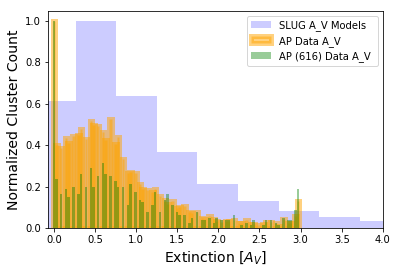

In [701]:
SLUGsample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
sbin_height,sbin_boundary = np.histogram(SLUGsample,bins=100)
#define width of each column
swidth = sbin_boundary[1]-sbin_boundary[0]
#standardize each column by dividing with the maximum height
sbin_height = sbin_height/float(max(sbin_height))
#plot
plt.bar(sbin_boundary[:-1],sbin_height,width=swidth,alpha=0.2,color='blue',label="SLUG A_V Models")


APsample = np.array(apdata['CMD_AV_BEST'])
#generate bins boundaries and heights
APbin_height, APbin_boundary = np.histogram(APsample,bins=100)
#define width of each column
APwidth = APbin_boundary[1]-APbin_boundary[0]
#standardize each column by dividing with the maximum height
APbin_height = APbin_height/float(max(APbin_height))
#plot
plt.bar(APbin_boundary[:-1],APbin_height,width=APwidth,edgecolor='orange',color='orange',alpha=0.5,label="AP Data A_V ",lw=5)

plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)



AP616sample = np.array(apdata_good_phot6filts['CMD_AV_BEST'])
#generate bins boundaries and heights
AP616bin_height, AP616bin_boundary = np.histogram(AP616sample,bins=100)
#define width of each column
AP616width = AP616bin_boundary[1]-AP616bin_boundary[0]
#standardize each column by dividing with the maximum height
AP616bin_height = AP616bin_height/float(max(AP616bin_height))
#plot
plt.bar(AP616bin_boundary[:-1],AP616bin_height,width=AP616width,color='green',
        alpha=0.4,label="AP (616) Data A_V ",lw=5)
plt.xlim(-0.07,4)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)

plt.show()

Text(0.5, 0, 'Extinction [$A_V$]')

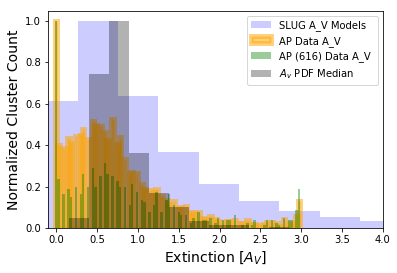

In [758]:
SLUGsample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
sbin_height,sbin_boundary = np.histogram(SLUGsample,bins=100)
#define width of each column
swidth = sbin_boundary[1]-sbin_boundary[0]
#standardize each column by dividing with the maximum height
sbin_height = sbin_height/float(max(sbin_height))
#plot
plt.bar(sbin_boundary[:-1],sbin_height,width=swidth,alpha=0.2,color='blue',label="SLUG A_V Models")


APsample = np.array(apdata['CMD_AV_BEST'])
#generate bins boundaries and heights
APbin_height, APbin_boundary = np.histogram(APsample,bins=100)
#define width of each column
APwidth = APbin_boundary[1]-APbin_boundary[0]
#standardize each column by dividing with the maximum height
APbin_height = APbin_height/float(max(APbin_height))
#plot
plt.bar(APbin_boundary[:-1],APbin_height,width=APwidth,edgecolor='orange',color='orange',alpha=0.5,label="AP Data A_V ",lw=5)

plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)



AP616sample = np.array(apdata_good_phot6filts['CMD_AV_BEST'])
#generate bins boundaries and heights
AP616bin_height, AP616bin_boundary = np.histogram(AP616sample,bins=100)
#define width of each column
AP616width = AP616bin_boundary[1]-AP616bin_boundary[0]
#standardize each column by dividing with the maximum height
AP616bin_height = AP616bin_height/float(max(AP616bin_height))
#plot
plt.bar(AP616bin_boundary[:-1],AP616bin_height,width=AP616width,color='green',
        alpha=0.4,label="AP (616) Data A_V ",lw=5)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)


XMedsample = np.array(xpercentiles[1][indBTM[0]])
#generate bins boundaries and heights
XMedbin_height, XMedbin_boundary = np.histogram(XMedsample,bins=100)
#define width of each column
XMedwidth = XMedbin_boundary[1]-XMedbin_boundary[0]
#standardize each column by dividing with the maximum height
XMedbin_height = XMedbin_height/float(max(XMedbin_height))
#plot
plt.bar(XMedbin_boundary[:-1],XMedbin_height,width=XMedwidth,color='black',alpha=0.3,label="$A_v$ PDF Median",lw=5)
plt.xlim(-0.1,4)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)

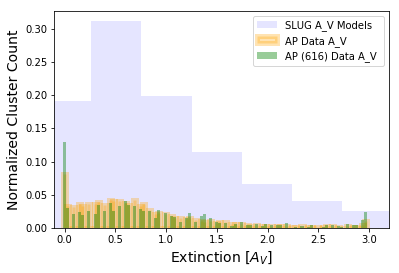

In [700]:
#Here I am running the same formula for normalizing both the SLUG and AP_data extinction values over the 
#y-axis by dividing the number of items in each bin by the max count of clusters in the data_set. 

SLUGsample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
sbin_height,sbin_boundary = np.histogram(SLUGsample,bins=100)
#define width of each column
swidth = sbin_boundary[1]-sbin_boundary[0]
#standardize each column by dividing with the maximum height
sbin_height = sbin_height/(10000000)
#plot
plt.bar(sbin_boundary[:-1],sbin_height,width=swidth,alpha=0.1,color='blue',label="SLUG A_V Models")


APsample = np.array(apdata['CMD_AV_BEST'])
#generate bins boundaries and heights
APbin_height, APbin_boundary = np.histogram(APsample,bins=100)
#define width of each column
APwidth = APbin_boundary[1]-APbin_boundary[0]
#standardize each column by dividing with the maximum height
APbin_height = APbin_height/(2753)
#plot
plt.bar(APbin_boundary[:-1],APbin_height,width=APwidth,edgecolor='orange',color='orange',alpha=0.3,label="AP Data A_V ",lw=5)
plt.xlim(-0.1,4)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)


AP616sample = np.array(apdata_good_phot6filts['CMD_AV_BEST'])
#generate bins boundaries and heights
AP616bin_height, AP616bin_boundary = np.histogram(AP616sample,bins=100)
#define width of each column
AP616width = AP616bin_boundary[1]-AP616bin_boundary[0]
#standardize each column by dividing with the maximum height
AP616bin_height = AP616bin_height/(616)
#plot
plt.bar(AP616bin_boundary[:-1],AP616bin_height,width=AP616width,color='green',
        alpha=0.4,label="AP (616) Data A_V ",lw=5)
plt.xlim(-0.1,3.2)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)


plt.show()

In [592]:
Norm_xbin_vals=[]
for i in range(len(Vals_of_xbins)):
    norm=(Vals_of_xbins[i]/616)
    Norm_xbin_vals.append(norm)
    

In [609]:
AP616bin_boundary[1]-AP616bin_boundary[0]

0.15

(-0.1, 3.2)

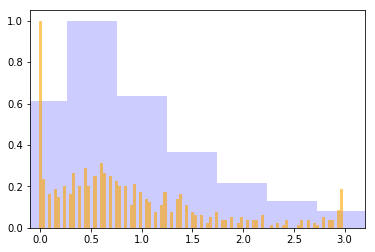

In [698]:
SLUGsample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
sbin_height,sbin_boundary = np.histogram(SLUGsample,bins=100)
#define width of each column
swidth = sbin_boundary[1]-sbin_boundary[0]
#standardize each column by dividing with the maximum height
sbin_height = sbin_height/float(max(sbin_height))
#plot
plt.bar(sbin_boundary[:-1],sbin_height,width=swidth,alpha=0.2,color='blue',label="SLUG A_V Models")
#plt.xlim(-0.3,4)


AP616sample = np.array(apdata_good_phot6filts['CMD_AV_BEST'])
#generate bins boundaries and heights
AP616bin_height, AP616bin_boundary = np.histogram(AP616sample,bins=100)
#define width of each column
AP616width = AP616bin_boundary[1]-AP616bin_boundary[0]
#standardize each column by dividing with the maximum height
AP616bin_height = AP616bin_height/float(max(AP616bin_height))
#plot
plt.bar(AP616bin_boundary[:-1],AP616bin_height, width=AP616width,alpha=0.6,color='orange',label="AP 616 Data A_V ",lw=5)
plt.xlim(-0.1,3.2)


(-0.07, 4)

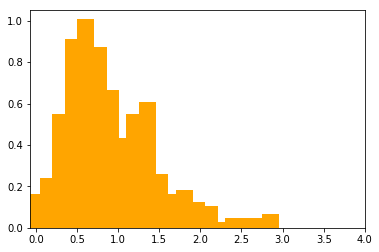

In [776]:
AP616sample = np.array(apdata_good_phot6filts['CMD_AV_BEST'][indBTM[0]])
#generate bins boundaries and heights
AP616bin_height, AP616bin_boundary = np.histogram(AP616sample,bins=20)
#define width of each column
AP616width = AP616bin_boundary[1]-AP616bin_boundary[0]
#standardize each column by dividing with the maximum height
AP616bin_height = AP616bin_height/float(max(AP616bin_height))
#plot
plt.bar(AP616bin_boundary[:-1],AP616bin_height, width=AP616width,edgecolor='orange',color='orange',label="AP 616 Data A_V ",lw=5)
plt.xlim(-0.07,4)

In [768]:
IND_SLUGav=np.where(LEGUS_PHAT_PadKroupa_prop['A_V']>=3.6)
LEGUS_PHAT_PadKroupa_prop.remove_rows(IND_SLUGav)

Text(0.5, 0, 'Extinction [$A_V$]')

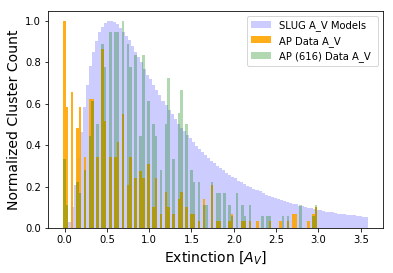

In [781]:
SLUG2sample = np.array(LEGUS_PHAT_PadKroupa_prop['A_V'])
#generate bins boundaries and heights
s2bin_height,s2bin_boundary = np.histogram(SLUG2sample,bins=100)
#define width of each column
s2width = s2bin_boundary[1]-s2bin_boundary[0]
#standardize each column by dividing with the maximum height
s2bin_height = s2bin_height/float(max(s2bin_height))
#plot
plt.bar(s2bin_boundary[:-1],s2bin_height,width=s2width,alpha=0.2,color='blue',label="SLUG A_V Models")
#plt.xlim(-0.3,4)


APsample = np.array(apdata['CMD_AV_BEST'][indBTM[0]])
#generate bins boundaries and heights
APbin_height, APbin_boundary = np.histogram(APsample,bins=100)
#define width of each column
APwidth = APbin_boundary[1]-APbin_boundary[0]
#standardize each column by dividing with the maximum height
APbin_height = APbin_height/float(max(APbin_height))
#plot
plt.bar(APbin_boundary[:-1],APbin_height,width=APwidth,color='orange',alpha=0.9,label="AP Data A_V ",lw=5)

plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)



AP616sample = np.array(apdata_good_phot6filts['CMD_AV_BEST'][indBTM[0]])
#generate bins boundaries and heights
AP616bin_height, AP616bin_boundary = np.histogram(AP616sample,bins=100)
#define width of each column
AP616width = AP616bin_boundary[1]-AP616bin_boundary[0]
#standardize each column by dividing with the maximum height
AP616bin_height = AP616bin_height/float(max(AP616bin_height))
#plot
plt.bar(AP616bin_boundary[:-1],AP616bin_height,width=AP616width,color='green',
        alpha=0.3,label="AP (616) Data A_V ",lw=5)
plt.legend()
plt.ylabel('Normalized Cluster Count',fontsize=14)
plt.xlabel('Extinction [$A_V$]',fontsize=14)

In [599]:
sorted_SLUG_Av=np.array(np.sort(LEGUS_PHAT_PadKroupa_prop['A_V']))
len(sorted_SLUG_Av)

10000000

Text(0, 0.5, 'Clusters')

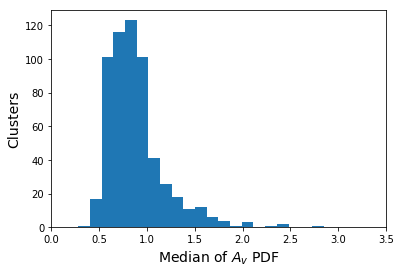

In [759]:
plt.hist(xpercentiles[1],bins=200)
plt.xlim(0,3.5)
plt.xlabel('Median of $A_v$ PDF',fontsize=14)
plt.ylabel('Clusters',fontsize=14)

ValueError: x must have 2 or fewer dimensions

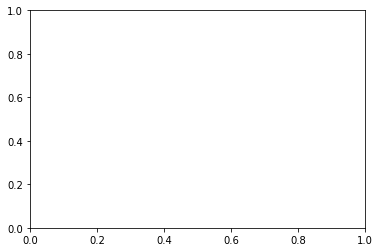

In [133]:
#x=np.arange(2,5,0.5)
#ax=plt.subplot()
#plt.subplot(1,2,1)
#plt.scatter((xpercentiles[1][indBTM[0]]),diff_PDFMedian_x_apdata, color='steelblue')
#plt.plot(x,np.median(diff_PDFMedian_m_apdata)*np.ones(6),'k--',lw=2)
#plt.plot(x,diff_PDFMedian_m_apdata_25q*np.ones(6),'b--',lw=2)
#plt.plot(x,diff_PDFMedian_m_apdata_75q*np.ones(6),'r--',lw=2)
#plt.ylabel('Difference of Models.', fontsize=13)
#plt.xlabel('Previous Log Mass Estimates', fontsize=13);


#plt.subplot(1,2,2)
#a=np.arange(0,180,1)
plt.hist(diff_PDFMedian_x_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
#plt.plot(a,np.median(diff_PDFMedian_m_apdata)*np.ones(180),'k--',lw=2,label='Median')
#plt.plot(a,diff_PDFMedian_m_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
#plt.plot(a,diff_PDFMedian_m_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
#plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/Model_Comparison_Files/DiffofMassModels_vs_PreviousMassEst.pdf')

In [611]:
min(LEGUS_PHAT_PadKroupa_prop['A_V'])

0.01675770387329732

(array([402., 290., 306., 339., 318., 265., 181., 131., 116.,  85.,  69.,
         50.,  34.,  25.,  25.,  19.,  11.,  18.,  17.,  52.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ],
       dtype=float32),
 <a list of 1 Patch objects>)

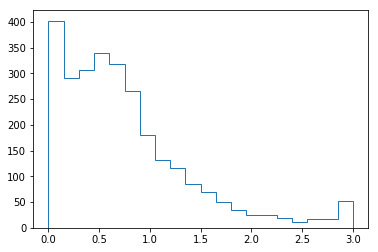

In [530]:
plt.hist(apdata['CMD_AV_BEST'],bins=20,histtype='step')